## Load Libraries

In [1]:
import numpy as np
import torch
import math
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams
from utils.utils import *
from dtw import dtw


np.random.seed(2)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# Set device
print(f'The device used in this notebook is: {setDevice()}')

DEVICE = setDevice()

The device used in this notebook is: cuda


## Import data

In [3]:
# Set settings
features, input_window, output_window, stride = set_settings()

print(f'features: {features}')
print(f'input_window: {input_window}')
print(f'output_window: {output_window}')
print(f'stride: {stride}')

features: ['Hips Flexion-Extension Left', 'Knees Flexion-Extension Left', 'Ankles Dorsiflexion-Plantarflexion Left', 'Hips Flexion-Extension Right', 'Knees Flexion-Extension Right', 'Ankles Dorsiflexion-Plantarflexion Right']
input_window: 100
output_window: 1
stride: 1


In [4]:
file_dir = r'D:\Study 2 Data\Healthy Gait\NYU Train_val' # Location of Healthy Gait Data
# file_dir = r'D:\Study 2 Data\CP Gait\Train' # Location of CP Gait Data 

train_files = os.listdir(file_dir) 

os.chdir(file_dir)
cwd = os.getcwd()

print(f'Current working directory is: {cwd}')
print(f"There are {len(train_files)} files in the specified path.")

Current working directory is: D:\Study 2 Data\Healthy Gait\NYU Train_val
There are 3 files in the specified path.


In [5]:
train_files

['AB2188 BF T1-5.csv', 'AB3154 BF T6-10.csv', 'AB9738 BF T1-5.csv']

In [6]:
#Create feature list to extract values needed from CSV files
all_features = ['Trial', 'Time'] + features
all_features


['Trial',
 'Time',
 'Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [7]:
#Extracts data from csv files and compiles them into a dataframe
all_data = create_dataframe(train_files, all_features)

Extracting data from: AB2188 BF T1-5.csv


Extracting data from: AB3154 BF T6-10.csv
Extracting data from: AB9738 BF T1-5.csv


In [8]:
all_data.reset_index(drop=True, inplace=True) #reset the index of the table
# path = r'D:\Study 2 Data\Healthy Gait' + '\\' + 'all_data_healthy_train.csv'
# all_data.to_csv(path)

In [9]:
all_data

,Patient ID,Trial,Time,Hips Flexion-Extension Left,Knees Flexion-Extension Left,Ankles Dorsiflexion-Plantarflexion Left,Hips Flexion-Extension Right,Knees Flexion-Extension Right,Ankles Dorsiflexion-Plantarflexion Right
0,AB2188 BF T1-5,1,223.83,24.69730,43.98116,13.16722,7.40105,19.83552,3.46198
1,AB2188 BF T1-5,1,223.84,24.44713,43.17039,13.07729,7.04358,19.57988,3.53245
2,AB2188 BF T1-5,1,223.85,24.17547,42.45852,13.01625,6.69202,19.29897,3.58736
3,AB2188 BF T1-5,1,223.86,23.88122,41.82635,12.98980,6.35465,19.00309,3.63057
4,AB2188 BF T1-5,1,223.87,23.56337,41.25273,13.00300,6.03926,18.70273,3.66602
...,...,...,...,...,...,...,...,...,...
22196,AB9738 BF T1-5,10,357.98,10.99086,7.10503,6.93556,24.15779,24.79361,-6.96295
22197,AB9738 BF T1-5,10,357.99,10.66388,6.95092,7.04563,23.36649,23.37365,-6.78526
22198,AB9738 BF T1-5,10,358.00,10.47453,6.99232,7.14855,22.59988,22.00132,-6.50384
22199,AB9738 BF T1-5,10,358.01,10.44759,7.27248,7.23479,21.89250,20.71157,-6.14128


In [10]:
n_trials = all_data['Trial'].max()
print(f'maximum number of trials is: {n_trials}')

maximum number of trials is: 10


In [11]:
all_data['Patient ID'].unique()

array(['AB2188 BF T1-5', 'AB3154 BF T6-10', 'AB9738 BF T1-5'],
      dtype=object)

In [12]:
# Divide subjects into training and validation set
train_subjects = ['AB2188 BF T1-5', 
                  'AB3154 BF T6-10',]

val_subjects = ['AB9738 BF T1-5']

In [13]:
train_data = all_data.loc[all_data['Patient ID'].isin(train_subjects)]

val_data = all_data.loc[all_data['Patient ID'].isin(val_subjects)]

In [14]:
print(f'all_data: {all_data.shape}')
print(f'train_data: {train_data.shape}')
print(f'val_data: {val_data.shape}')

all_data: (22201, 9)
train_data: (13769, 9)
val_data: (8432, 9)


In [15]:
# Count the number of trials and time-points for each patient in th train and validation set
train_samples = count_nsamples(train_data)
val_samples = count_nsamples(val_data)

For patient: AB2188 BF T1-5, trial: 1, there are: 718 time-points
For patient: AB2188 BF T1-5, trial: 2, there are: 801 time-points
For patient: AB2188 BF T1-5, trial: 3, there are: 706 time-points
For patient: AB2188 BF T1-5, trial: 4, there are: 651 time-points
For patient: AB2188 BF T1-5, trial: 5, there are: 741 time-points
For patient: AB2188 BF T1-5, trial: 6, there are: 691 time-points
For patient: AB2188 BF T1-5, trial: 7, there are: 722 time-points
For patient: AB2188 BF T1-5, trial: 8, there are: 726 time-points
For patient: AB2188 BF T1-5, trial: 9, there are: 740 time-points
For patient: AB2188 BF T1-5, trial: 10, there are: 766 time-points
For patient: AB3154 BF T6-10, trial: 1, there are: 651 time-points
For patient: AB3154 BF T6-10, trial: 2, there are: 541 time-points
For patient: AB3154 BF T6-10, trial: 3, there are: 613 time-points
For patient: AB3154 BF T6-10, trial: 4, there are: 601 time-points
For patient: AB3154 BF T6-10, trial: 5, there are: 711 time-points
For 

In [16]:
print(f'Number of train samples: {train_samples}')
print(f'Number of validation samples: {val_samples}')

Number of train samples: 19
Number of validation samples: 9


In [17]:
# m = all_data['Patient ID'].unique()

In [18]:
# #copied to utils
# def pd_to_np_converter(data, n_samples, features):
#     #create a numpy array that stores the data for export
#     sample_ID = []
#     # patients = 2
#     # n_trials = 10
#     # # samples = patients * n_trials
#     data_store = np.zeros((n_samples, 2000, len(features)), dtype=np.float32)
#     i = 0

#     for p in data['Patient ID'].unique(): #loop over patients 
#         for t in data['Trial'].unique(): #loop over trials starting with trials 1 to trial 9 (inclusive)
#             pd_array = data[(data['Patient ID'] == p) & (data['Trial'] == t)]
#             if pd_array.empty:
#                 continue
#                 # print('DataFrame is empty!')
#                 # print(f'Trail {t} does not exist in {p}')
#             else:
#                 np_array = pd_array.to_numpy()
#                 data_store[i, :np_array.shape[0], :] = np_array[:,3:] 
#                 sample_ID.append(p+ ' Ts'+str(t)) 
#                 i +=1

#     return pd_array.columns, data_store


In [19]:
train_columns, train_data_np = pd_to_np_converter(train_data, train_samples, features)
val_columns, val_data_np = pd_to_np_converter(val_data, val_samples, features)

print(f'train_data_np.shape: {train_data_np.shape}')
print(f'val_data_np.shape: {val_data_np.shape}')

train_data_np.shape: (19, 2000, 6)
val_data_np.shape: (9, 2000, 6)


In [20]:
train_columns[3:].tolist() 

['Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [21]:
features == train_columns[3:].tolist() 

True

In [22]:
labels_keys = train_columns[3:].tolist() #copy the train columns removing the first column headers'Patient ID', 'Trial', 'Time'


if features == labels_keys: # check that the features are the same as the label keys 
    print('Yay!! Column headers of dataframe match features')
else:
    print('ERROR: Features and labels_keys do not match!')

Yay!! Column headers of dataframe match features


In [23]:
labels_keys = features 

labels_idx = np.arange(0, len(labels_keys), 1)

labels = dict(zip(labels_keys, labels_idx))

len(labels)
labels
# labels_keys

{'Hips Flexion-Extension Left': 0,
 'Knees Flexion-Extension Left': 1,
 'Ankles Dorsiflexion-Plantarflexion Left': 2,
 'Hips Flexion-Extension Right': 3,
 'Knees Flexion-Extension Right': 4,
 'Ankles Dorsiflexion-Plantarflexion Right': 5}

In [24]:
# Creating training datasets
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 900


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_train_windows = np.zeros((samples_per_file*train_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_train_windows = np.zeros((samples_per_file*train_samples, output_window, len(features)), dtype=np.float32)


start_idx = 0 #setting start index to equal zero 
train_sample_sum = 0
train_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(train_samples): 
       
    X_values, Y_values = window_generator_fltrd(
        train_data_np[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_train_windows[start_idx:end_idx, :, :] = X_values
    Y_train_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    train_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_train_data = X_train_windows[:end_idx, :, :].astype('float64')
Y_train_data = Y_train_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_train_windows: {X_train_windows.shape}')
print(f'shape of Y_train_windows: {Y_train_windows.shape}')

print(f'shape of X_train_data: {X_train_data.shape}')
print(f'shape of Y_train_data: {Y_train_data.shape}')

trimmed_seqLen: 718
trimmed_seqLen_reduced: 418
number of slides is: 318
trimmed_seqLen: 801
trimmed_seqLen_reduced: 501
number of slides is: 401
trimmed_seqLen: 706
trimmed_seqLen_reduced: 406
number of slides is: 306
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 741
trimmed_seqLen_reduced: 441
number of slides is: 341
trimmed_seqLen: 691
trimmed_seqLen_reduced: 391
number of slides is: 291
trimmed_seqLen: 722
trimmed_seqLen_reduced: 422
number of slides is: 322
trimmed_seqLen: 726
trimmed_seqLen_reduced: 426
number of slides is: 326
trimmed_seqLen: 740
trimmed_seqLen_reduced: 440
number of slides is: 340
trimmed_seqLen: 766
trimmed_seqLen_reduced: 466
number of slides is: 366
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 541
trimmed_seqLen_reduced: 241
number of slides is: 141
trimmed_seqLen: 613
trimmed_seqLen_reduced: 313
number of slides is: 213
trimmed_seqLen: 601
trimmed_seqLen_reduced: 301
num

In [25]:
# Creating validation datasets
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_val_windows = np.zeros((samples_per_file*val_samples, output_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
val_sample_sum = 0
val_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(val_samples): 
       
    X_values, Y_values = window_generator_fltrd(
        val_data_np[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_val_windows[start_idx:end_idx, :, :] = X_values
    Y_val_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    val_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_data = X_val_windows[:end_idx, :, :].astype('float64')
Y_val_data = Y_val_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_windows: {X_val_windows.shape}')
print(f'shape of Y_val_windows: {Y_val_windows.shape}')

print(f'shape of X_val_data: {X_val_data.shape}')
print(f'shape of Y_val_data: {Y_val_data.shape}')

trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 496
trimmed_seqLen: 981
trimmed_seqLen_reduced: 681
number of slides is: 581
trimmed_seqLen: 1001
trimmed_seqLen_reduced: 701
number of slides is: 601
trimmed_seqLen: 906
trimmed_seqLen_reduced: 606
number of slides is: 506
trimmed_seqLen: 958
trimmed_seqLen_reduced: 658
number of slides is: 558
trimmed_seqLen: 951
trimmed_seqLen_reduced: 651
number of slides is: 551
trimmed_seqLen: 904
trimmed_seqLen_reduced: 604
number of slides is: 504
trimmed_seqLen: 926
trimmed_seqLen_reduced: 626
number of slides is: 526
trimmed_seqLen: 909
trimmed_seqLen_reduced: 609
number of slides is: 509
shape of X_val_windows: (14400, 100, 6)
shape of Y_val_windows: (14400, 1, 6)
shape of X_val_data: (4832, 100, 6)
shape of Y_val_data: (4832, 1, 6)


In [26]:
# Creating validation datasets (long term predictions)
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600

future_window = 200

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_lt_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_val_lt_windows = np.zeros((samples_per_file*val_samples, future_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
val_lt_sample_sum = 0
val_lt_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(val_samples): 
       
    X_values, Y_values = window_generator_lt_fltrd(
        val_data_np[i,:,:],
        input_window=input_window, 
        future_window=future_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_val_lt_windows[start_idx:end_idx, :, :] = X_values
    Y_val_lt_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    val_lt_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_lt_data = X_val_lt_windows[:end_idx, :, :].astype('float64')
Y_val_lt_data = Y_val_lt_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_lt_windows: {X_val_lt_windows.shape}')
print(f'shape of Y_val_lt_windows: {Y_val_lt_windows.shape}')

print(f'shape of X_val_lt_data: {X_val_lt_data.shape}')
print(f'shape of Y_val_lt_data: {Y_val_lt_data.shape}')

trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 297
trimmed_seqLen: 981
trimmed_seqLen_reduced: 681
number of slides is: 382
trimmed_seqLen: 1001
trimmed_seqLen_reduced: 701
number of slides is: 402
trimmed_seqLen: 906
trimmed_seqLen_reduced: 606
number of slides is: 307
trimmed_seqLen: 958
trimmed_seqLen_reduced: 658
number of slides is: 359
trimmed_seqLen: 951
trimmed_seqLen_reduced: 651
number of slides is: 352
trimmed_seqLen: 904
trimmed_seqLen_reduced: 604
number of slides is: 305
trimmed_seqLen: 926
trimmed_seqLen_reduced: 626
number of slides is: 327
trimmed_seqLen: 909
trimmed_seqLen_reduced: 609
number of slides is: 310
shape of X_val_lt_windows: (14400, 100, 6)
shape of Y_val_lt_windows: (14400, 200, 6)
shape of X_val_lt_data: (3041, 100, 6)
shape of Y_val_lt_data: (3041, 200, 6)


In [27]:
# Set values of the scalars needed to normalise the data (scalars represent maximum and minimum joint angles ranges in the data)
scalars= np.array([[-45., -45., -90., -45., -45., -90.], [100., 120., 45., 100., 120., 45.]])

In [28]:
scalars

array([[-45., -45., -90., -45., -45., -90.],
       [100., 120.,  45., 100., 120.,  45.]])

In [29]:
# X_train_norm, scalars = normalise_fit(X_train_data)
X_train_norm = normalise_transform(X_train_data, scalars)
Y_train_norm = normalise_transform(Y_train_data, scalars)

X_val_norm = normalise_transform(X_val_data, scalars)
Y_val_norm = normalise_transform(Y_val_data, scalars)

X_val_lt_norm = normalise_transform(X_val_lt_data, scalars)
Y_val_lt_norm = normalise_transform(Y_val_lt_data, scalars)

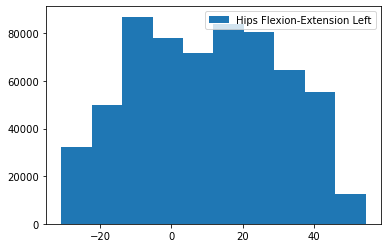

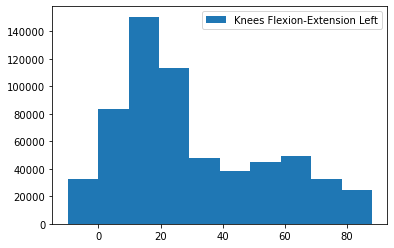

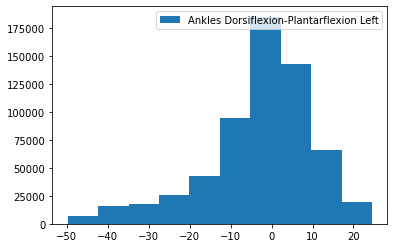

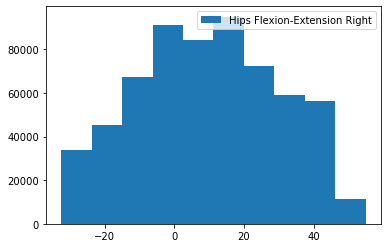

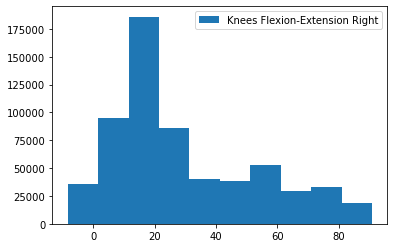

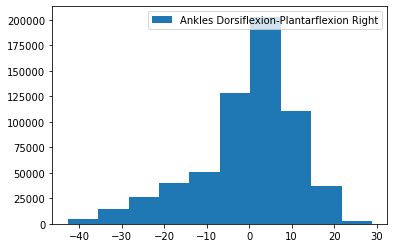

In [30]:
for i in range(6):
    plt.hist(X_train_data[:,:,i].reshape(-1,1), label=features[i])
    plt.legend()
    plt.show()

In [31]:
# Convert to Tensor 
# do not store on GPU (yet)
X_train = torch.from_numpy(X_train_norm).to(torch.float64)
Y_train = torch.from_numpy(Y_train_norm).to(torch.float64)

# X_val = torch.from_numpy(X_val_norm).float()

# X_val_resized = np.expand_dims(Y_val_norm[:,0,:], axis=1)
# Y_val = torch.from_numpy(X_val_resized).float()

X_val = torch.from_numpy(X_val_norm).to(torch.float64)
Y_val = torch.from_numpy(Y_val_norm).to(torch.float64)


X_val_lt = torch.from_numpy(X_val_lt_norm).to(torch.float64)
Y_val_lt = torch.from_numpy(Y_val_lt_norm).to(torch.float64)


print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

print(f'X_val_lt shape: {X_val_lt.shape}') #long term predictions
print(f'Y_val_lt shape: {Y_val_lt.shape}') #long term predictions




X_train shape: torch.Size([6169, 100, 6])
Y_train shape: torch.Size([6169, 1, 6])
X_val shape: torch.Size([4832, 100, 6])
Y_val shape: torch.Size([4832, 1, 6])
X_val_lt shape: torch.Size([3041, 100, 6])
Y_val_lt shape: torch.Size([3041, 200, 6])


In [32]:
X_val.dtype

torch.float64

In [33]:
train_dataset = gaitDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle = True)
# train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle = False) #256

val_dataset = gaitDataset(X_val, Y_val) #ADJUSTED
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=len(train_dataset), shuffle=False)


val_lt_dataset = gaitDataset(X_val_lt, Y_val_lt) #long term predictions
val_lt_dataloader = DataLoader(val_lt_dataset, batch_size=256, shuffle=False)


print(f"Train Dataset length: {len(train_dataset)}")
print(f"Val Dataset length: {len(val_dataset)}")
print(f"Val_lt Dataset length: {len(val_lt_dataset)}")


Train Dataset length: 6169
Val Dataset length: 4832
Val_lt Dataset length: 3041


In [34]:
# len(train_dataloader)

## Set the Architecture of the DL Models


In [35]:
print(f'shape of X_train: {X_train.shape}, shape of Y_train: {Y_train.shape}')

shape of X_train: torch.Size([6169, 100, 6]), shape of Y_train: torch.Size([6169, 1, 6])


In [36]:
look_back = 100

In [37]:
# #Vanilla LSTM
# class Net(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(Net, self).__init__()
        
#         # self.fc1 = nn.Linear(input_shape, n_neurons)
#         self.lstm = nn.LSTM(input_size=input_shape, hidden_size=n_neurons)
#         self.fc = nn.Linear(n_neurons, 1)
    
#     def forward(self, x):
#         out, _ = self.lstm(x)
#         # out = self.fc1(x)
#         out = self.fc(out)
#         return out

In [38]:
# # Vanilla LSTM
# class LSTM(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(LSTM, self).__init__()
        
#         self.lstm = nn.LSTM(input_size=len(features), hidden_size=n_neurons, num_layers=2, batch_first = True)
#         self.fc = nn.Linear(n_neurons, len(features))

#     def forward(self, x):
#         # print(f'input shape: {x.shape}')
#         out, _ = self.lstm(x)

#         out = self.fc(out[:,-1])

#         return out.unsqueeze(1)

In [39]:
# LSTM model 
class LSTM(nn.Module):
    def __init__(self, n_neurons, look_back):
        super(LSTM, self).__init__()
        '''
        nn.lstm: 
        input_size = number of features in input, if batch_first = TRUE (batchSize, seq_len, Hin) FEATURES
        hidden_size = number of features in hidden state
        num_layers
        batch_first = if TRUE (batch, seq, Hin) Hin may mean input features
        h_0 = (D * num_layers, batchSize, Hout)
        c_0 = (D * num_layers, batchSize, Hcell)

        output = (batchSize, seq_len, D * Hout) Hout may mean output features, if batch first = TRUE 
        h_0 = (D*num_layers, N, Hout) final state for each element in the batch 
        C_0 = (D*num_layers, N, Hcell) final cell state for each element 

        nn.linear:
        input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
        output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 

        '''
        # Pytorch documentation: 
        # >>> rnn = nn.LSTM(10, 20, 2) features, hidden_size, number of layers 
        # >>> input = torch.randn(5, 3, 10) in_seq_len, batch_size, hidden_size (batch size should not be input to the mode, inferred from the shape of the input and will be the first number if batch_first = TRUE)
        # >>> h0 = torch.randn(2, 3, 20)
        # >>> c0 = torch.randn(2, 3, 20)
        # >>> output, (hn, cn) = rnn(input, (h0, c0))

        self.input_size = len(features)
        self.hidden_size = n_neurons
        self.num_layers = 2
        self.in_seq_len = look_back
        self.output_size = len(features)
        self.out_seq_len = output_window
        self.device = DEVICE
        
        # nn.LSTM(features, hidden_size, number of layers)
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first = True)


        self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


    def forward(self, input_data):

        # initialise hidden and cell states after passing through each batch (this is skipped in stateless model)
        h_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).double().to(self.device) # input_data.shape[0] is equal to batch size
        c_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).double().to(self.device)

        #propagate through LSTM
        lstm_out, (h_out, c_out) = self.lstm(input_data, (h_0, c_0))
        # print(f'shape h_out[-1] {h_out.shape}')
        # propagate through linear layer 
        fc1_out = self.fc1(h_out[-1])
       
        preds = fc1_out.reshape(input_data.shape[0], self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')
        
        return preds

In [96]:
class MLP(nn.Module):
    def __init__(self, n_neurons, input_shape):
        super(MLP, self).__init__()
        # self.flatten = nn.Flatten()
        self.input_size = len(features)
        self.output_size = len(features)
        self.in_seq_len = input_shape
        self.out_seq_len = 1
        self.device = DEVICE 
        self.layers = 3
        self.num_units = 200
        

        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        linear_layers_lst = [] #linear layer list
 
        for i in range(self.layers):
            linear_layers_lst.append(nn.Linear(self.num_units, self.num_units))
            linear_layers_lst.append(nn.ReLU())

       
        linear_layers = tuple((linear_layers_lst))

        self.MLP = nn.Sequential(nn.Linear(in_features=self.input_size*self.in_seq_len, out_features=self.num_units), 
                                nn.ReLU(), 
                                *linear_layers, 
                                nn.Linear(self.num_units, self.output_size*self.out_seq_len))

        # self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print(f'shape of x: {x.shape}')
        out = self.flatten(x)
        # x is in the shape [batch_size, in_seq_len, features], but should be reshaped to [batch_size, in_seq_len*features]
        # print(f'shape of flatten: {out.shape}')
        out = self.MLP(out)
        # print(f'shape of MLP: {out.shape}')
        out = self.sigmoid(out)
        preds = out.reshape(x.shape[0],  self.out_seq_len,self.output_size)
        return preds

In [97]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        '''
        nn.Conv1d
        in_channels: number of features in input 
        out_channels: number of channels in output
        kernel_size: size of convolving layer
        stride: convolution stride
        padding=0
        dilation=1
        groups=1
        bias=True
        padding_mode='zeros'
        device=device 
        dtype=None

        nn.MaxPool1d
        kernel_size:
        stride=None: default is kernel_size
        padding=0:
        dilation=1
        return_indices=False
        ceil_mode=False

        torch.flatten (reshapes to 1D vector)
        input
        start_dim=0
        end_dim=- 1

        nn.Linear 
        input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
        output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 
        '''
        # Pytorch documentation: 
        # >>> m = nn.Conv1d(16, 33, 3, stride=2) features(in_channels), output_channels, kernel_size
        # >>> input = torch.randn(20, 16, 50) batch_size, features, length of sequence 
        # >>> output = m(input~)


        # >>> m = nn.MaxPool1d(3, stride=2) kernel_size, stride
        # >>> input = torch.randn(20, 16, 50)
        # >>> output = m(input)
    
        self.input_size = len(features)
        self.output_size = len(features)
        # self.kernel_size = kernel_size
        # self.stride = stride
        self.device = DEVICE 
        self.in_seq_len = input_window
        self.out_seq_len = output_window
        self.conv1_channels = 32
        self.conv2_channels = 48
        self.conv3_channels = 256
        self.conv4_channels = 256
        self.kernel_12 = 3
        self.kernel_34 = 3
        self.padding = 2
        self.stride = 2
        self.dilation = 1

        def calc_shape(input, kernel_size, stride, padding=0, dilation =1, operation = 'conv'):
            if operation == 'conv':
            # size = ((input - kernel_size + (2 * padding))/stride)  + 1 
                size = ((input + 2 * padding - dilation * (kernel_size-1) -1)/stride )+ 1

            if operation == 'pool':
                size = ((input - kernel_size)/stride)  + 1

            return size

        self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = self.conv1_channels, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding, dilation=self.dilation)
        post_conv1 = calc_shape(input = self.in_seq_len, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv1: {post_conv1}')

        self.conv2 = nn.Conv1d(in_channels = self.conv1_channels, out_channels = self.conv2_channels, kernel_size = self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv2 = calc_shape(input = post_conv1, kernel_size =self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation,  operation='conv')
        # print(f'post conv2: {post_conv2}')

        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool1 = calc_shape(input = post_conv2, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post poo1: {post_pool1}')

        self.conv3 = nn.Conv1d(in_channels=self.conv2_channels, out_channels=self.conv3_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation )
        post_conv3 = calc_shape(input = post_pool1, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding, dilation=self.dilation, operation='conv')
        # print(f'post conv3: {post_conv3}')


        self.conv4 = nn.Conv1d(in_channels=self.conv3_channels, out_channels=self.conv4_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv4 = calc_shape(input = post_conv3, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv4: {post_conv4}')


        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool2 = calc_shape(input = post_conv4, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post pool2: {post_pool2}')

        # print(f'linear input: {post_pool2 * 32}')

        self.fc1 = nn.Linear(in_features = (int(post_pool2) * self.conv4_channels), out_features=(self.output_size * self.out_seq_len))
        #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


    def forward(self, input_data):
        '''
        input_data.shape = 
        '''
        # print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
        input = input_data.permute(0,2,1)
        out = self.conv1(input)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
        out = self.pool1(out)
        # print(f'pool1 out shape = {out.shape}')
        out = self.conv3(out)
        # print(f'conv2 out shape: {out.shape}')
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
        # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
        out = self.fc1(out)
        # print(f'fc1 out shape: {out.shape}')
        preds = out.reshape(input_data.shape[0],  self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')

        return preds

In [98]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe.requires_grad = False
        #pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        #x = x + self.pe[:x.size(0), :]#Variable(self.pe[:x.size(0), :], requires_grad=False)
        x = x + self.pe[:x.size(1), :].unsqueeze(0).repeat(x.size(0), 1, 1) ## modified by Bing to adapt to batch
        return self.dropout(x)
        # return x

In [99]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()

        # self.device = device
        self.feature_size = len(features)
        # self.out_seq_len = 6
        self.d_model= 80


        # self.t2v = Time2Vec(input_dim=len(features), embed_dim=self.d_model, act_function=torch.sin).to(DEVICE)
        self.enc_in = nn.Linear(len(features), self.d_model)
        self.dec_in = nn.Linear(len(features), self.d_model)
        self.pe = PositionalEncoding(d_model = self.d_model, dropout = 0.2).to(DEVICE)
        self.transformer = nn.Transformer(d_model=self.d_model, nhead = 8, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=100, dropout=0.1, batch_first=True)
        self.linear = nn.Linear(80 ,len(features))
        # self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        # print(f'input shape: {x.shape}')
        src = self.enc_in(x)
        # print(f'linear layer output shape: {src.shape}')
        src = self.pe(src)


        # print(f'after positional encoding: {out.shape}')

        # tgt = self.pe(x[:,:-1,:])
        # tgt = self.pe(x[:,-1,:].unsqueeze(1))
        tgt = self.dec_in(x[:,-1,:].unsqueeze(1))
        # print(f'linear layer output shape (decoder): {tgt.shape}')
        tgt = self.pe(tgt)

        out = self.transformer(src, tgt)
        # output of decoder shape: torch.Size([batch_size, 99, input_embed])
        # print(f'output of transfoermer: {out.shape}')
        
        out = out.reshape(out.shape[0], -1)
        # print(f'reshaped transfoer out: {out.shape}')

        out = self.linear(out)
        out = self.sigmoid(out)
        out = out.reshape(x.shape[0], 1, self.feature_size)
        # print(f'output of decoder shape: {out.shape}')

        
        return out

## Train Model

In [100]:
# DEVICE = 'cpu'
DEVICE = 'cuda'

In [69]:
fname = 'NYU_test'
folder_path = r'D:\Study 2 Results and Models\NUY test' + '\\' + fname 
path = r'D:\Study 2 Results and Models\NUY test' + '\\' + fname + '\\'  + fname + '.pth'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
else:
    print('File already exists, choose a different name')
    raise 
    

File already exists, choose a different name


RuntimeError: No active exception to reraise

In [101]:
n_neurons = 200
# model = CNN().double().to(DEVICE)
model = MLP(n_neurons, look_back).double().to(DEVICE)
# model = Transformer().double().to(DEVICE)
# model = LSTM(n_neurons, look_back).double().to(DEVICE)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loss = []
val_loss = []
lt_loss = []
dtw_loss = []

lowest_dtw = 1000.

epochs = 2

for epoch in tqdm(range(epochs)):
    train_loss_total = 0.
    i = 0
    model.train()
    for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
        i += 1
        model.zero_grad()
        # print(f'train_labels shape: {batch_inputs.shape}')

        batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
        
        # print(f'batch_inputs.shape {batch_inputs.shape}')
        predictions = model(batch_inputs)
        # print(f'predictions.shape {predictions.shape}')
        # print(f'train_labels shape: {batch_targets.shape}')
        loss = loss_function(predictions, batch_targets)

        train_loss_total += loss.item()
        loss.backward()
        optimizer.step()
    # print(f'len(dataloader): {len(train_dataloader)}')
    train_loss_total = train_loss_total/len(train_dataloader)
    train_loss.append(train_loss_total)

    # Calculate validation loss
    model.eval()
    with torch.no_grad():
        val_loss_total = 0.
        for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
            

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
            predictions = model(batch_inputs)
            # print(f'train_labels shape: {train_labels.shape}')
            loss = loss_function(predictions, batch_targets)
            val_loss_total += loss.item()
    
    val_loss_total = val_loss_total/len(val_dataloader)
    val_loss.append(val_loss_total)

    # Calculating long term loss
    model.eval()
    with torch.no_grad():
        lt_loss_total = 0.
        dtw_total = 0.

        for idx, (batch_inputs, batch_targets) in enumerate(val_lt_dataloader):

            extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)
            # print(f'extrapolation.shape: {extrapolation.shape}')

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
            current_inputs = batch_inputs
            for i in range(200):
                # print(f'current_inputs.shape {current_inputs.shape}')
                predictions = model(current_inputs)
                # print(f'predictions.shape {predictions.shape}')

                extrapolation[:,i,:] = predictions.squeeze(1)
                # print(f'current_inputs[:,1:,:].shape {current_inputs[:,1:,:].shape}')
                # print(f'predictions.shape {predictions.shape}')

                #concat shape [batch_size, 99, len(features)] and [batch_size, 1, len(features)]
                current_inputs = torch.cat((current_inputs[:,1:,:], predictions), axis=1)

            loss = loss_function(extrapolation, batch_targets)
    
            lt_loss_total += loss.item()

            #dtw
            running_dtw = 0.
            for s in range(batch_targets.shape[0]):
                for f in range(len(features)):
                    dis = dtw(extrapolation[s,:,f].squeeze().cpu(),batch_targets[s,:,f].squeeze().cpu(), distance_only=True).distance
                    
                    running_dtw += dis

            dtw_total += running_dtw / (batch_targets.shape[0] * len(features))

    lt_loss_total = lt_loss_total/len(val_lt_dataloader)
    lt_loss.append(lt_loss_total)

    dtw_total = dtw_total / (len(val_lt_dataloader))
    dtw_loss.append(dtw_total)

    # plot one sample of extraplation 

    if epoch % 5 == 0:
        x1 = np.arange(0,100)
        x3 = np.arange(101,301)

        fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
        n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

        text_size = 11
        for f in range(len(features)):
            axs[n[f][0],n[f][1]].plot(x1, batch_inputs[0,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
            axs[n[f][0],n[f][1]].plot(x3, extrapolation[0,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='g',linestyle='dashed', label='extrapolation')
            axs[n[f][0],n[f][1]].plot(x3, batch_targets[0,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
            axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
            axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
            axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

        plt.legend()
        plt.show()
        

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss_total}, Val Loss: {val_loss_total}, lt Loss: {lt_loss_total}, dtw distance: {dtw_total}')


    if dtw_total < lowest_dtw:
        print('New model saved!')
        lowest_dtw = dtw_total
        
        checkpoint = {'model': model,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, path)

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for t in range(epochs):
    print(f'Epoch{t+1}: train_loss: {train_loss[t]}, val_loss: {val_loss[t]}, lt_loss: {lt_loss[t]}, dtw_loss: {dtw_loss[t]}')

Epoch1: train_loss: 0.028930289056179337, val_loss: 0.024702887670684872, lt_loss: 0.024829987301690056, dtw_loss: 27.90669388638952
Epoch2: train_loss: 0.01947095187305138, val_loss: 0.013743857087835466, lt_loss: 0.013882138632735639, dtw_loss: 20.22919521096068


## Load Saved Model

In [121]:
saved_model_path = r'D:\Study 2 Results and Models\NUY test\NYU_test' + '\\' + 'Exp079_221103_FCN_wide_norm' + '.pth'
saved_model_path = r'trained-models\Exp079_221103_FCN_wide_norm.pth'
np.loadcsv("../data/all_data_healthy_train.csv.csv")
# saved_model_path = r'../Exp079_221103_FCN_wide_norm.pth'


NameError: name 'read' is not defined

In [125]:
from pandas import read_csv
import glob
 
glob.glob('../data/all_data_healthy_train.csv')

[]

In [120]:
#load model 
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint(saved_model_path)

FileNotFoundError: [Errno 2] No such file or directory: '../Exp079_221103_FCN_wide_norm.pth'

In [104]:
model.eval()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (MLP): Sequential(
    (0): Linear(in_features=600, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): ReLU()
    (8): Linear(in_features=200, out_features=6, bias=True)
  )
  (sigmoid): Sigmoid()
)

## Plot of Training Loss Curves 

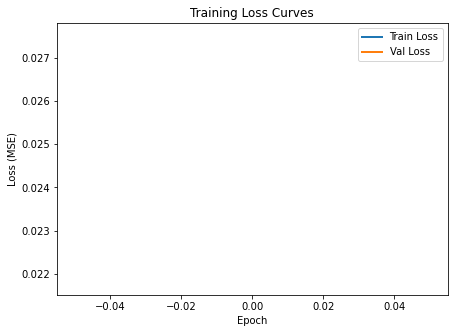

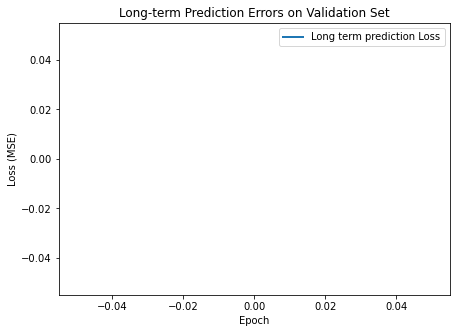

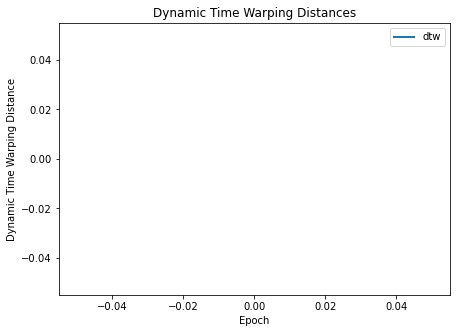

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(train_loss[:], lw=2, label='Train Loss')
ax.plot(val_loss[:], lw=2, label='Val Loss')

ax.set_title("Training Loss Curves")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(lt_loss[:], lw=2, label='Long term prediction Loss')

ax.set_title("Long-term Prediction Errors on Validation Set")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(dtw_loss, lw=2, label='dtw')
ax.set_title("Dynamic Time Warping Distances")
ax.set_xlabel("Epoch")
ax.set_ylabel("Dynamic Time Warping Distance")
ax.legend()
plt.show()

# fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# ax.set_title("Plot of the Log of Loss Curves")
# ax.plot(np.log(train_loss[:]), lw=2, label='Train Loss')
# ax.plot(np.log(val_loss[:]), lw=2, label='Val Loss')
# ax.plot(np.log(lt_loss[:]), lw=2, label='Long term prediction Loss')

# ax.set_xlabel("Epoch")
# ax.set_ylabel("Log Loss (MSE)")
# ax.legend()
# plt.show()

## Load Test Set

In [106]:
test_dataset = X_val_lt.to(DEVICE)
with torch.no_grad():
    test_predictions = model(test_dataset)

test_predictions.shape

torch.Size([3041, 1, 6])

## Visualisation of Predictions (one-step-ahead predictions)

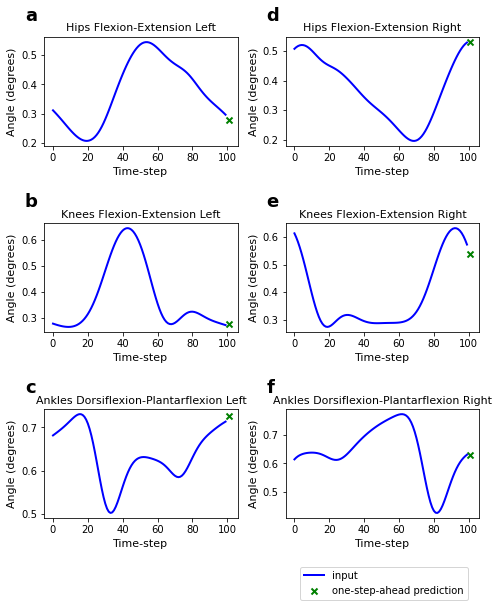

In [107]:
x1 = np.arange(0,100)
x2 = 101
s=500 #sample used for paper

fig, axs = plt.subplots(nrows=3, ncols=2, tight_layout=True, figsize=(7,9))
n = [[0,0], [1,0], [2,0], [0,1], [1,1], [2,1]] #indicies for the plots

text_size = 11
alpha = ['a', 'b', 'c', 'd', 'e', 'f']
for f in range(len(features)):
    # axs[n[f][0],n[f][1]].text(-0.1, 1, alpha[f], size=20, weight='bold', transform=axs[0,0].transAxes)
    axs[n[f][0],n[f][1]].plot(x1, test_dataset[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='b', label = 'input')
    axs[n[f][0],n[f][1]].scatter(x2, test_predictions[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, marker = 'x', c='g', label='one-step-ahead prediction')
    # axs[n[f][0],n[f][1]].scatter(x2, actual_denorm[0,0,f], lw=2, marker = 'x', c='r', label='actual')

    axs[n[f][0],n[f][1]].set_xlabel('Time-step', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (degrees)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)
    axs[n[f][0],n[f][1]].text(-0.1, 1.15, alpha[f], size=18, weight='bold', transform=axs[n[f][0],n[f][1]].transAxes)


# axLine, axLabel = ax.get_legend_handles_labels()
plt.legend(loc='lower left', bbox_to_anchor=(0.05, -0.8))

## Visualisation of Long-term Predictions (200-timesteps in the future)

In [108]:
extrapolation = torch.zeros((1,200, len(features))).to(DEVICE)
seed_batch = test_dataset[s,:,:].unsqueeze(0).to(DEVICE)
current_batch = seed_batch
with torch.no_grad():
    for i in range(200):
        predicted_value = model(current_batch)
        extrapolation[:,i,:] = predicted_value
        current_batch = torch.cat((current_batch[:,1:,:], predicted_value), axis=1)

seed_batch.shape

torch.Size([1, 100, 6])

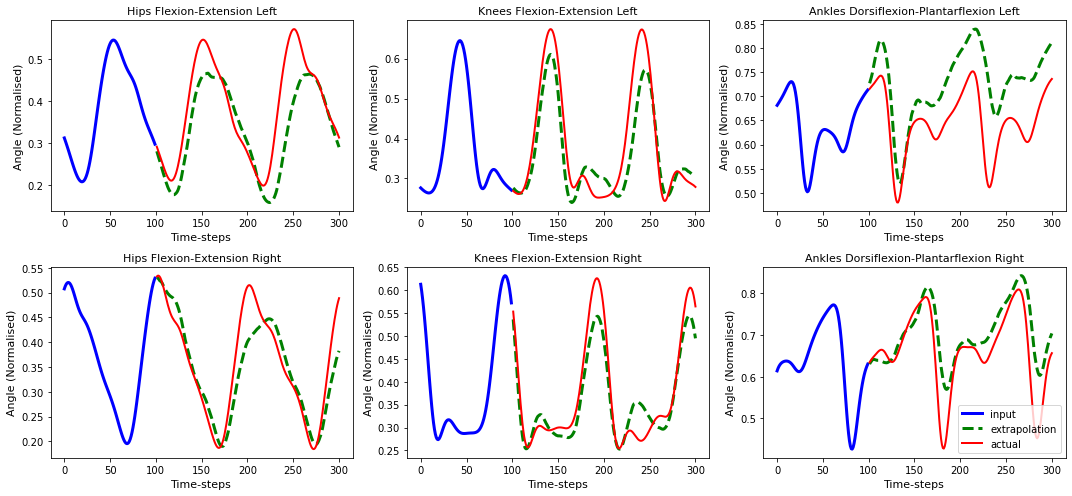

In [109]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11
for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, seed_batch[:,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
    axs[n[f][0],n[f][1]].plot(x3, extrapolation[:,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='extrapolation')
    axs[n[f][0],n[f][1]].plot(x3, Y_val_lt[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

plt.legend()


## Calculating MSE and MAE

In [110]:
print(f'shape of X validation data: {X_val.shape}, Y validation data: {Y_val.shape}')

shape of X validation data: torch.Size([4832, 100, 6]), Y validation data: torch.Size([4832, 1, 6])


In [111]:
# Calculate predictions
model.eval()
with torch.no_grad():
    test_predictions = model(X_val.to(DEVICE))

#Denormalise X_val and Y_val and predictions 
input_val = denormalise(X_val.cpu().numpy(), scalars)
actual_val = denormalise(Y_val.cpu().numpy(), scalars)
preds_val = denormalise(test_predictions.cpu().numpy(), scalars)

In [112]:
val_mse_loss, val_mse_std = mse_loss(preds_val, actual_val, reduction='mean', format='np')
val_mae_loss, val_mae_std = mae_loss(preds_val, actual_val, reduction='mean', format='np')

print(f'Val MSE Loss: {val_mse_loss:.5}, Val MSE std: {val_mse_std:.5}')
print(f'Val MAE Loss: {val_mae_loss:.5}, Val MAE std: {val_mae_std:.5}')


Val MSE Loss: 3.0064, Val MSE std: 4.3183
Val MAE Loss: 1.376, Val MAE std: 1.055


## Errors for Each Joint

In [113]:
for f in range(len(features)):
    print(f' Error for {features[f]} is: {np.mean(abs(preds_val[:,:,f]-actual_val[:,:,f])):.3f}')

 Error for Hips Flexion-Extension Left is: 1.238
 Error for Knees Flexion-Extension Left is: 1.604
 Error for Ankles Dorsiflexion-Plantarflexion Left is: 1.480
 Error for Hips Flexion-Extension Right is: 1.231
 Error for Knees Flexion-Extension Right is: 1.459
 Error for Ankles Dorsiflexion-Plantarflexion Right is: 1.243


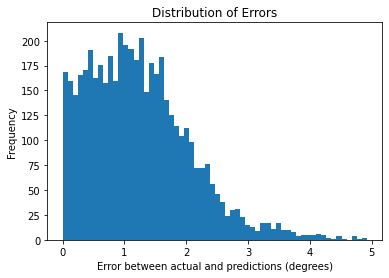

In [114]:
#Plotting the Distribution of Errors
diff = abs(preds_val[:,:,0] -actual_val[:,:,0])
plt.hist(diff.squeeze(), 60)
plt.xlabel('Error between actual and predictions (degrees)')
plt.title('Distribution of Errors')
plt.ylabel('Frequency')
plt.show()